In [ ]:
from scipy.io import arff
from operator import index

import numpy as np
from sklearn.neighbors import NearestNeighbors, KernelDensity
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.stats import gaussian_kde, multivariate_normal
import seaborn as sns
from sklearn import preprocessing
import math

from statsmodels.sandbox.panel.sandwich_covariance_generic import kernel

plt.rcParams['figure.figsize'] = [15, 7]

In [130]:
arff_file = arff.loadarff('./clusters/artificial/cluto-t4-8k.arff')
df = pd.DataFrame(arff_file[0])

In [131]:
df.head()

,x,y,CLASS
0,68.601997,102.491997,b'0'
1,454.665985,264.808990,b'2'
2,101.283997,169.285995,b'noise'
3,372.614990,263.140991,b'2'
4,300.989014,46.555000,b'5'


In [132]:
X = df.iloc[:,:2].values
y = df.iloc[:,2]
le = LabelEncoder()
y = le.fit_transform(y)

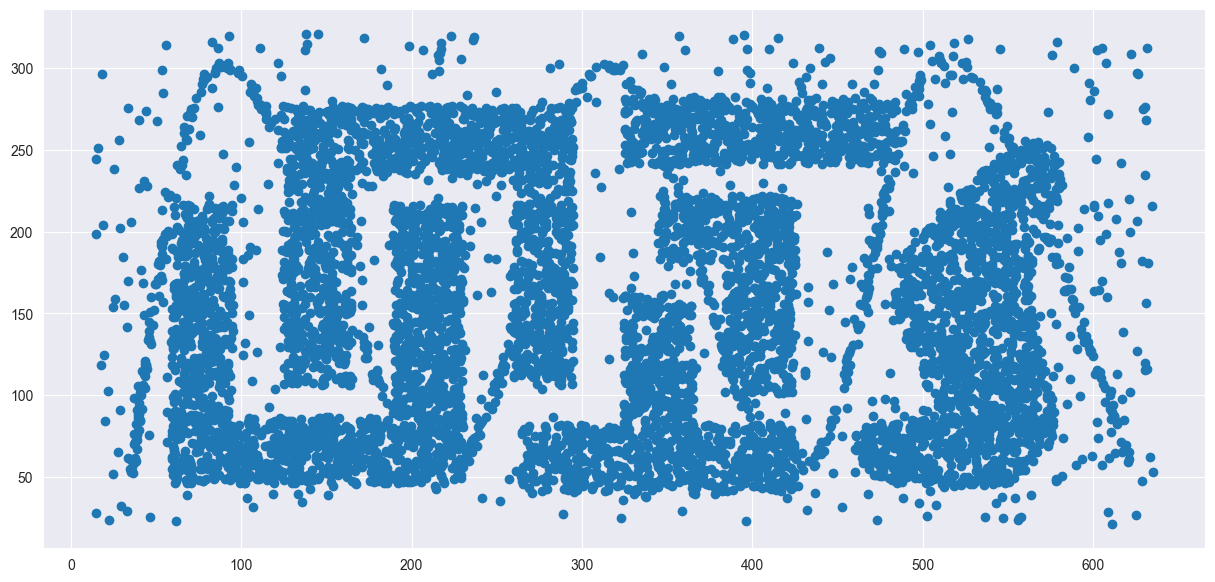

In [133]:
plt.scatter(X[:,0],X[:,1])

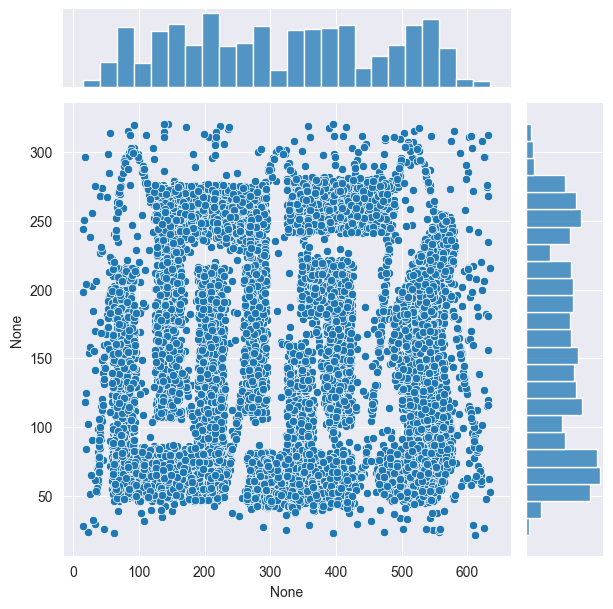

In [134]:
sns.jointplot(x= X[:,0],y=X[:,1],data=df)
plt.show()

In [135]:
def main(X,y,n):
    nn = NearestNeighbors(n_neighbors=n)
    nn.fit(X)
    dist, knn = nn.kneighbors(X)  # returns N index neighbors including self
    return knn, dist

knn, distReturn = main(X,y,2)

In [136]:
def generateArr(newDist, median='median'):
    arr = []
    for x in newDist:  # finds the distance away from that point (index 0)
        if median == 'median':
            arr += [np.median(x)]
        elif median == 'sum': # min + median + max
            arr += [x[1]+np.max(x)+np.median(x)]
        elif median == 'max':
            arr += [np.max(x)]
        elif median == 'minMax':
            arr += [np.max(x)+x[1]]
        elif median == 'medMax':
            arr += [np.median(x)+np.max(x)]
        elif median == 'min':
            arr += [x[1]]
            

    return arr

distReturn = np.array(distReturn)
arr = generateArr(distReturn, median="max")

In [137]:
q3 = np.quantile(arr, 0.75)
size = 100
spaced = np.linspace(0,330,num=size)

0.0001174996883615884
1.2452052675226845e-05
7075


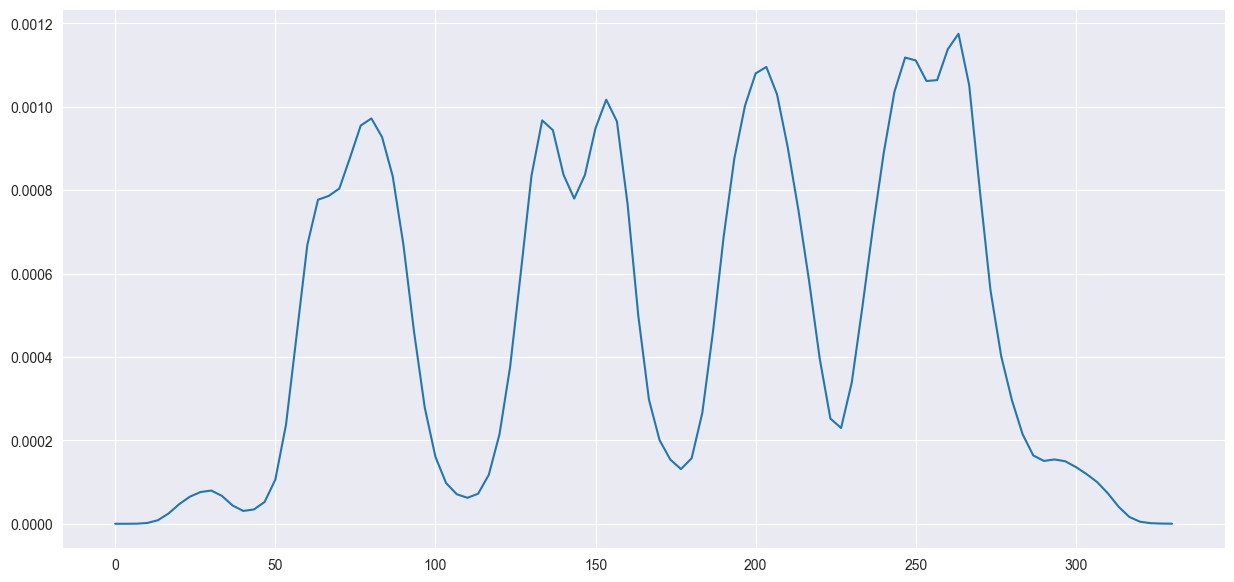

In [138]:
#density function
pdf = np.array([])
totalPdf = []
mean1 = np.mean(X[:,0])
mean2 = np.mean(X[:,1])
sigma = q3*3

for a in range(X.shape[0]):
    for t in spaced:
        w = pow((t-X[a][0]),2)
        q = pow((t-X[a][1]),2)
        expTotal = -((w+q) / (2*pow(sigma,2)))
        e = math.exp(expTotal)
        bottom = (2*math.pi) * (pow(sigma,2))
        bottomR = 1 / bottom
        density = bottomR * e
        pdf = np.append(pdf,density)
    
    pdf = pdf / size
    totalPdf += [list(pdf)]
    pdf = np.array([])

#print(np.sum(totalPdf[625]))
arrToHold = []
kernelAdd = list(map(sum,zip(*totalPdf)))
print(max(kernelAdd)*.1)

sumDen = []
for r in totalPdf:
    sumDen += [np.sum(r)]

print(max(sumDen)*.1)
newOuts = sumDen < max(sumDen)*.01
outliers_new = X[newOuts]
print(len(outliers_new))
plt.plot(spaced,kernelAdd)
plt.show()

(100, 100)
5.332680024166244e-06


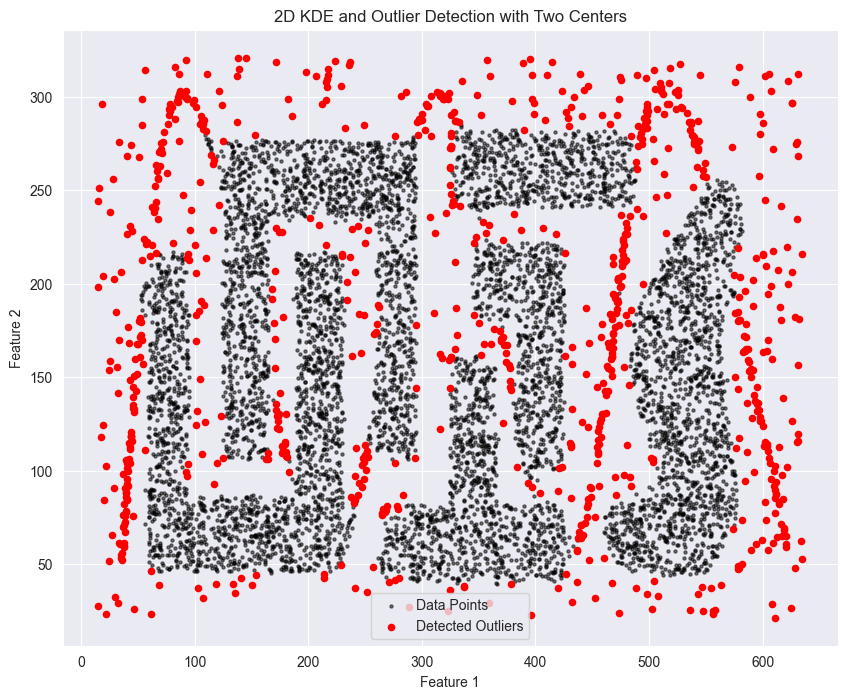

In [187]:
def gaussian_kernel(u):
    # u is the standardized distance between data points and evaluation points
    # d is the number of dimensions (features) of the data
    d = u.shape[1]
    # normalization constant for the Gaussian kernel in d dimensions
    normalization = (2 * np.pi) ** (-d / 2)
    # compute the Gaussian function
    return normalization * np.exp(-0.5 * np.sum(u**2, axis=1))

# Multidimensional KDE implementation
def kde_2d(x, data, bandwidth):
    # n: number of data points
    n = data.shape[0]
    # d: dimensionality of the data
    d = x.shape[1]
    # Initialize an array to store the density estimate at each point in x
    estimate = np.zeros(x.shape[0])
    # Loop over each data point to compute its contribution to the density estimate
    for i in range(n):
        # Calculate the standardized distance u using the bandwidth
        u = (x - data[i]) / bandwidth
        # Accumulate the Gaussian kernel contributions from each data point
        estimate += gaussian_kernel(u)
    # Normalize the density estimate by the number of points and the bandwidth raised to the dimensionality
    estimate /= (n * (bandwidth ** d))
    return estimate

# Generate sample data with 2 features and 2 centers
#np.random.seed(42)  # For reproducibility
#data_center1 = np.random.normal(0, 1, (500, 2))
#data_center2 = np.random.normal(5, 1, (500, 2))

# Manually add a few outliers
outliers = np.array([[10, 10], [11, 11], [-3, 10], [7, -5]])
#data = np.vstack((data_center1, data_center2, outliers))
data = X

# Create a grid for KDE evaluation and visualization
x = np.linspace(min(X[:, 0]) - 2, max(X[:, 0]) + 2, 100)
y2 = np.linspace(min(X[:, 1]) - 2, max(X[:, 1]) + 2, 100)
X3, Y = np.meshgrid(x, y2)
xy = np.vstack([X3.ravel(), Y.ravel()]).T

# Compute KDE on the grid
bandwidth = 3*q3  # Bandwidth affects the smoothness of the KDE
pdf = kde_2d(xy, data, bandwidth).reshape(X3.shape)
print(pdf.shape)
# Detect outliers: points with very low probability density
#threshold = np.mean(pdf)+.000002 # Threshold for density to consider a point an outlier
threshold = np.max(pdf)*.3 
outlier_mask = kde_2d(data, data, bandwidth) < threshold
print(threshold)
detected_outliers = data[outlier_mask]
yOuts = y[outlier_mask]
# Plotting the results
plt.figure(figsize=(10, 8))
#plt.contourf(X, Y, pdf, levels=50, cmap='Blues')  # Density plot
#plt.colorbar(label='Density')
plt.scatter(data[:, 0], data[:, 1], s=5, color='k', alpha=0.5, label='Data Points')  # Data points
plt.scatter(detected_outliers[:, 0], detected_outliers[:, 1], s=20, color='red', label='Detected Outliers')  # Outliers
plt.title('2D KDE and Outlier Detection with Two Centers')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [188]:
affer = 0
for f in yOuts:
    if f == 6:
        affer += 1

print(affer,yOuts.shape)

700 (824,)


In [142]:
newK = gaussian_kde(X.T)

In [143]:
newPoints = newK.evaluate(X.T)

In [144]:
print(newPoints)

[5.95462436e-06 7.88949029e-06 6.88149312e-06 ... 7.21423870e-06
 1.06696901e-05 7.41692649e-06]


6
[25, 44, 62, 123, 130, 143, 164, 186, 217, 232, 235, 255, 259, 264, 302, 360, 363, 370, 372, 373, 376, 422, 426, 440, 472, 521, 534, 543, 587, 599, 610, 621, 622, 624, 629, 650, 683, 685, 692, 723, 730, 749, 778, 827, 842, 896, 900, 917, 937, 955, 956, 971, 990, 994, 1009, 1021, 1030, 1034, 1044, 1060, 1086, 1116, 1136, 1142, 1145, 1175, 1176, 1179, 1187, 1191, 1197, 1209, 1221, 1251, 1257, 1274, 1283, 1328, 1347, 1376, 1396, 1405, 1408, 1413, 1421, 1438, 1457, 1499, 1502, 1526, 1551, 1561, 1575, 1577, 1580, 1588, 1613, 1648, 1656, 1660, 1676, 1685, 1710, 1746, 1756, 1773, 1806, 1842, 1903, 1910, 1946, 1955, 1956, 1983, 1986, 1992, 1994, 2002, 2007, 2017, 2040, 2056, 2070, 2075, 2097, 2104, 2143, 2146, 2163, 2200, 2281, 2302, 2342, 2357, 2379, 2386, 2431, 2432, 2433, 2465, 2470, 2497, 2525, 2529, 2552, 2556, 2564, 2592, 2642, 2674, 2709, 2732, 2754, 2768, 2769, 2774, 2811, 2859, 2951, 2955, 2970, 2993, 2999, 3014, 3018, 3027, 3034, 3036, 3039, 3062, 3064, 3075, 3102, 3108, 3138, 3156

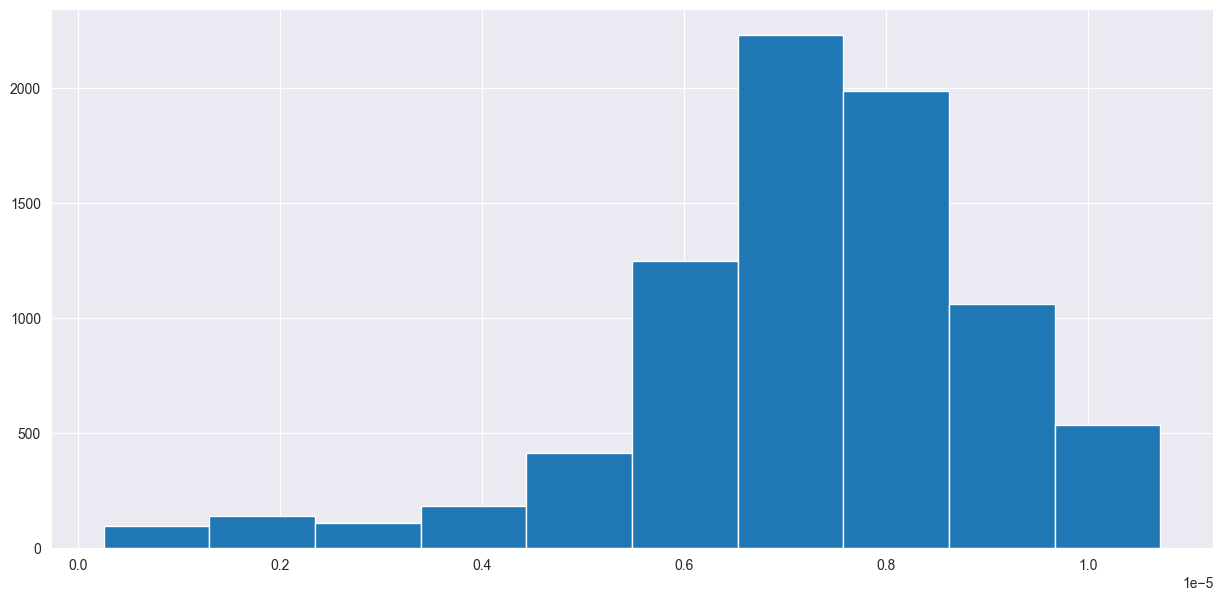

In [145]:
Z = np.max(newPoints)*.4
points = newPoints[newPoints < Z]
holder = []
for p in points:
    holder += [list(newPoints).index(p)]
print(y[holder[5]])
print(holder)
plt.hist(newPoints)
plt.show()

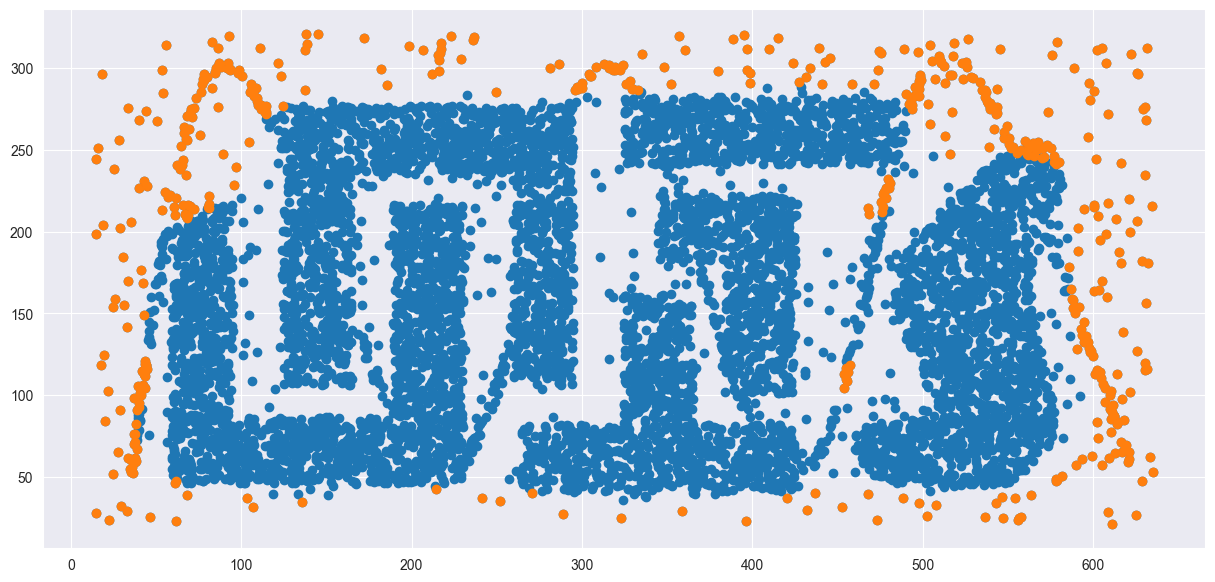

In [146]:
holderVals = []
for tm in holder:
    holderVals += [X[tm]]

holderVals = np.array(holderVals)
plt.scatter(X[:,0],X[:,1])
plt.scatter(holderVals[:,0],holderVals[:,1])
plt.show()